In [1]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [38]:
def load_satellite(num_training=4035, num_validation=400, num_test=2000):
    train = np.loadtxt('data/sat_train.txt')
    test = np.loadtxt('data/sat_test.txt')
    
    X_train, y_train = train[:,:36],train[:,-1].astype(int)
    X_train = scale(X_train, np.min(X_train, axis=0), np.max(X_train, axis=0))
    
    X_test, y_test = test[:, :36], test[:,36].astype(int)
    X_test = scale(X_test, np.min(X_test, axis=0), np.max(X_test, axis=0))
    
    y_train[y_train == 7] = 6
    y_train -= 1
    
    y_test[y_test == 7] = 6
    y_test -= 1
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = load_satellite()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (4035, 36)
Train labels shape:  (4035,) int64
Validation data shape:  (400, 36)
Validation labels shape:  (400,)
Test data shape:  (2000, 36)
Test labels shape:  (2000,)


In [39]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=True):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.seed(0)
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=32, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=32, shuffle=True)
test_dset = Dataset(X_test, y_test, batch_size=32)

In [4]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (32, 36) (32,)
1 (32, 36) (32,)
2 (32, 36) (32,)
3 (32, 36) (32,)
4 (32, 36) (32,)
5 (32, 36) (32,)
6 (32, 36) (32,)


In [5]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /cpu:0


In [6]:
def two_layer_fc(x, params):
    """
    A fully-connected neural network; the architecture is:
    fully-connected layer -> Sigmoid -> fully connected layer.
    Note that we only need to define the forward pass here; TensorFlow will take
    care of computing the gradients for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.

    Inputs:
    - x: A TensorFlow Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of TensorFlow Tensors giving weights for the
      network, where w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A TensorFlow Tensor of shape (N, C) giving classification scores
      for the input data x.
    """
    w1, w2 = params  # Unpack the parameters
#     x = flatten(x)   # Flatten the input; now x has shape (N, D)
    h = tf.nn.sigmoid(tf.matmul(x, w1)) # Hidden layer: h has shape (N, H)
    scores = tf.matmul(h, w2)        # Compute scores of shape (N, C)
    return scores

In [7]:
def two_layer_fc_test():
    # TensorFlow's default computational graph is essentially a hidden global
    # variable. To avoid adding to this default graph when you rerun this cell,
    # we clear the default graph before constructing the graph we care about.
    tf.reset_default_graph()
    hidden_layer_size = 42

    # Scoping our computational graph setup code under a tf.device context
    # manager lets us tell TensorFlow where we want these Tensors to be
    # placed.
    with tf.device(device):
        # Set up a placehoder for the input of the network, and constant
        # zero Tensors for the network weights. Here we declare w1 and w2
        # using tf.zeros instead of tf.placeholder as we've seen before - this
        # means that the values of w1 and w2 will be stored in the computational
        # graph itself and will persist across multiple runs of the graph; in
        # particular this means that we don't have to pass values for w1 and w2
        # using a feed_dict when we eventually run the graph.
        x = tf.placeholder(tf.float32)
        w1 = tf.zeros((36, hidden_layer_size))
        w2 = tf.zeros((hidden_layer_size, 6))
        
        # Call our two_layer_fc function to set up the computational
        # graph for the forward pass of the network.
        scores = two_layer_fc(x, [w1, w2])
    
    # Use numpy to create some concrete data that we will pass to the
    # computational graph for the x placeholder.
    x_np = np.zeros((64, 36))
    with tf.Session() as sess:
        # The calls to tf.zeros above do not actually instantiate the values
        # for w1 and w2; the following line tells TensorFlow to instantiate
        # the values of all Tensors (like w1 and w2) that live in the graph.
        sess.run(tf.global_variables_initializer())
        
        # Here we actually run the graph, using the feed_dict to pass the
        # value to bind to the placeholder for x; we ask TensorFlow to compute
        # the value of the scores Tensor, which it returns as a numpy array.
        scores_np = sess.run(scores, feed_dict={x: x_np})
        print(scores_np.shape)

two_layer_fc_test()

(64, 6)


In [8]:
def training_step(scores, y, params, learning_rate):
    """
    Set up the part of the computational graph which makes a training step.

    Inputs:
    - scores: TensorFlow Tensor of shape (N, C) giving classification scores for
      the model.
    - y: TensorFlow Tensor of shape (N,) giving ground-truth labels for scores;
      y[i] == c means that c is the correct class for scores[i].
    - params: List of TensorFlow Tensors giving the weights of the model
    - learning_rate: Python scalar giving the learning rate to use for gradient
      descent step.
      
    Returns:
    - loss: A TensorFlow Tensor of shape () (scalar) giving the loss for this
      batch of data; evaluating the loss also performs a gradient descent step
      on params (see above).
    """
    # First compute the loss; the first line gives losses for each example in
    # the minibatch, and the second averages the losses acros the batch
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
    loss = tf.reduce_mean(losses)

    # Compute the gradient of the loss with respect to each parameter of the the
    # network. This is a very magical function call: TensorFlow internally
    # traverses the computational graph starting at loss backward to each element
    # of params, and uses backpropagation to figure out how to compute gradients;
    # it then adds new operations to the computational graph which compute the
    # requested gradients, and returns a list of TensorFlow Tensors that will
    # contain the requested gradients when evaluated.
    grad_params = tf.gradients(loss, params)
    
    # Make a gradient descent step on all of the model parameters.
    new_weights = []   
    for w, grad_w in zip(params, grad_params):
        new_w = tf.assign_sub(w, learning_rate * grad_w)
        new_weights.append(new_w)

    # Insert a control dependency so that evaluting the loss causes a weight
    # update to happen; see the discussion above.
    with tf.control_dependencies(new_weights):
        return tf.identity(loss)

In [9]:
def train_part2(model_fn, init_fn, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model
      using TensorFlow; it should have the following signature:
      scores = model_fn(x, params) where x is a TensorFlow Tensor giving a
      minibatch of image data, params is a list of TensorFlow Tensors holding
      the model weights, and scores is a TensorFlow Tensor of shape (N, C)
      giving scores for all elements of x.
    - init_fn: A Python function that initializes the parameters of the model.
      It should have the signature params = init_fn() where params is a list
      of TensorFlow Tensors holding the (randomly initialized) weights of the
      model.
    - learning_rate: Python float giving the learning rate to use for SGD.
    """
    # First clear the default graph
    tf.reset_default_graph()
    is_training = tf.placeholder(tf.bool, name='is_training')
    # Set up the computational graph for performing forward and backward passes,
    # and weight updates.
    with tf.device(device):
        # Set up placeholders for the data and labels
        x = tf.placeholder(tf.float32, [None, 36])
        y = tf.placeholder(tf.int32, [None])
        params = init_fn()           # Initialize the model parameters
        scores = model_fn(x, params) # Forward pass of the model
        loss = training_step(scores, y, params, learning_rate)

    # Now we actually run the graph many times using the training data
    with tf.Session() as sess:
        # Initialize variables that will live in the graph
        sess.run(tf.global_variables_initializer())
        for t, (x_np, y_np) in enumerate(train_dset):
            # Run the graph on a batch of training data; recall that asking
            # TensorFlow to evaluate loss will cause an SGD step to happen.
            feed_dict = {x: x_np, y: y_np}
            loss_np = sess.run(loss, feed_dict=feed_dict)
            
            # Periodically print the loss and check accuracy on the val set
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss_np))
                check_accuracy(sess, val_dset, x, scores, is_training)

In [10]:
def check_accuracy(sess, dset, x, scores, is_training=None, verbose=False):
    """
    Check accuracy on a classification model.
    
    Inputs:
    - sess: A TensorFlow Session that will be used to run the graph
    - dset: A Dataset object on which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - scores: A TensorFlow Tensor representing the scores output from the
      model; this is the Tensor we will ask TensorFlow to evaluate.
      
    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

In [11]:
def kaiming_normal(shape):
    if len(shape) == 2:
        fan_in, fan_out = shape[0], shape[1]
    elif len(shape) == 4:
        fan_in, fan_out = np.prod(shape[:3]), shape[3]
    return tf.random_normal(shape) * np.sqrt(1.0 / fan_in)

In [12]:
def two_layer_fc_init():
    """
    Initialize the weights of a two-layer network, for use with the
    two_layer_network function defined above.
    
    Inputs: None
    
    Returns: A list of:
    - w1: TensorFlow Variable giving the weights for the first layer
    - w2: TensorFlow Variable giving the weights for the second layer
    """
    hidden_layer_size = 10
    w1 = tf.Variable(kaiming_normal((36, hidden_layer_size)))
    w2 = tf.Variable(kaiming_normal((hidden_layer_size, 10)))
    return [w1, w2]

learning_rate = 1e-2
train_part2(two_layer_fc, two_layer_fc_init, learning_rate)

Iteration 0, loss = 1.6108
Iteration 100, loss = 2.0623


In [13]:
class TwoLayerFC(tf.keras.Model):
    def __init__(self, hidden_size, num_classes):
        super().__init__()        
        initializer = tf.variance_scaling_initializer(scale=1.0, seed=0)
        regularizer = tf.contrib.layers.l2_regularizer(scale=10e-6)
        self.fc1 = tf.layers.Dense(hidden_size, activation=tf.nn.sigmoid,
                                   kernel_regularizer=regularizer,
                                   kernel_initializer=initializer)
        self.fc2 = tf.layers.Dense(num_classes,
                                   kernel_regularizer=regularizer,
                                   kernel_initializer=initializer)
    def call(self, x, training=None):
#         x = tf.layers.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


def test_TwoLayerFC():
    """ A small unit test to exercise the TwoLayerFC model above. """
    tf.reset_default_graph()
    input_size, hidden_size, num_classes = 50, 42, 10

    # As usual in TensorFlow, we first need to define our computational graph.
    # To this end we first construct a TwoLayerFC object, then use it to construct
    # the scores Tensor.
    model = TwoLayerFC(hidden_size, num_classes)
    with tf.device(device):
        x = tf.zeros((64, input_size))
        scores = model(x)

    # Now that our computational graph has been defined we can run the graph
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        scores_np = sess.run(scores)
        print(scores_np.shape)
        
test_TwoLayerFC()

(64, 10)


In [57]:
def train_part34(model_init_fn, optimizer_init_fn, num_epochs=1, verbose=False):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    
    Returns: Nothing, but prints progress during training
    """
    tf.reset_default_graph()    
    with tf.device(device):
        # Construct the computational graph we will use to train the model. We
        # use the model_init_fn to construct the model, declare placeholders for
        # the data and labels
        x = tf.placeholder(tf.float32, [None, 36])
        y = tf.placeholder(tf.int32, [None])
        
        # We need a place holder to explicitly specify if the model is in the training
        # phase or not. This is because a number of layers behaves differently in
        # training and in testing, e.g., dropout and batch normalization.
        # We pass this variable to the computation graph through feed_dict as shown below.
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        # Use the model function to build the forward pass.
        scores = model_init_fn(x, is_training)

        # Compute the loss like we did in Part II
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)

        # Use the optimizer_fn to construct an Optimizer, then use the optimizer
        # to set up the training step. Asking TensorFlow to evaluate the
        # train_op returned by optimizer.minimize(loss) will cause us to make a
        # single update step using the current minibatch of data.
        
        # Note that we use tf.control_dependencies to force the model to run
        # the tf.GraphKeys.UPDATE_OPS at each training step. tf.GraphKeys.UPDATE_OPS
        # holds the operators that update the states of the network.
        # For example, the tf.layers.batch_normalization function adds the running mean
        # and variance update operators to tf.GraphKeys.UPDATE_OPS.
        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)

    # Now we can run the computational graph many times to train the model.
    # When we call sess.run we ask it to evaluate train_op, which causes the
    # model to update.
    errors = []
    accuracies = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
#             print('Starting epoch %d' % epoch)
            for x_np, y_np in train_dset:
                feed_dict = {x: x_np, y: y_np, is_training:1}
                loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                t += 1                
            accuracy = check_accuracy(sess, val_dset, x, scores, is_training=is_training)
            errors.append(loss_np)
            accuracies.append(accuracy)
        if verbose:
            print('Iteration %d, loss = %.4f' % (t, loss_np))
            print()
    return errors, accuracies


In [15]:
hidden_size, num_classes = 10, 6
learning_rate = 1e-2

def model_init_fn(inputs, is_training):
    return TwoLayerFC(hidden_size, num_classes)(inputs)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

errors, accuracies = train_part34(model_init_fn, optimizer_init_fn, num_epochs=1)
# print(errors, accuracies)

In [46]:
learning_rate = 1e-2
regularizer = tf.contrib.layers.l2_regularizer(scale=10e-6)
num_epoch = 500
def model_init_fn(inputs, is_training):
    hidden_layer_size, num_classes = 10, 6
    initializer = tf.variance_scaling_initializer(scale=1.0, seed=0)
    layers = [
        tf.layers.Dense(hidden_layer_size, activation=tf.nn.sigmoid,
                        kernel_regularizer=regularizer,
                        kernel_initializer=initializer),
        tf.layers.Dense(num_classes,
                        kernel_regularizer=regularizer,
                        kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model(inputs)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

errors, accuracies = train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epoch)
# print(errors, accuracies)

fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
ax1.plot(range(len(errors)), errors)
ax2.plot(range(len(accuracies)), accuracies)
plt.xlabel('epoch')
ax1.set_ylabel('Train Errors')
ax2.set_ylabel('Validation accuracy')
plt.show()

In [49]:
batch_sizes = [4, 8, 16, 32, 64]
num_epoch = 500
acc = []
err = []
for size in batch_sizes:
    print('batch size:', size)
    train_dset = Dataset(X_train, y_train, batch_size=size, shuffle=True)
    val_dset = Dataset(X_val, y_val, batch_size=size, shuffle=True)
    test_dset = Dataset(X_test, y_test, batch_size=size)
    
    errors, accuracies = train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epoch)
    acc.append(accuracies)
    err.append(errors)
# print('Accuracies:')
# print(acc)
# print('Errors:')
# print(err)

# for i in range(len(batch_sizes)):
#     plt.plot(range(num_epoch), err[i], label='batch size = {}'.format(batch_sizes[i]))

# plt.xlabel('epochs')
# plt.ylabel('Train error')
# plt.legend()
# plt.show()


batch size: 4
batch size: 8
batch size: 16
batch size: 32
batch size: 64


In [50]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1) 
for i in range(len(batch_sizes)):
    ax1.plot(range(num_epoch), err[i], label='batch size = {}'.format(batch_sizes[i]))
    ax2.plot(range(num_epoch), acc[i], label='batch size = {}'.format(batch_sizes[i]))

plt.xlabel('epoch')
ax1.set_ylabel('Train Errors')
ax2.set_ylabel('Validation accuracy')
# ax1.legend(loc='upper right')
# ax2.legend(loc='upper right')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [36]:
print('Accuracies:')
print(acc)
print('Errors:')
print(err)

Accuracies:
[[0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325], [0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325], [0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325], [0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635], [0.0, 0.0, 0.0, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.6325, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635, 0.635]]
Errors:
[[0.63623834, 0.6447728, 0.6447485, 0.6447485, 0.6447485, 0.6447485, 0.64474845, 0.64474845, 0.64474845, 0.6447485, 0.6447486, 0.6447484, 0.64474845, 0.6447486, 0.6447485, 0.6447485, 0.6447485, 0.64474

In [58]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

time_function(train_part34, model_init_fn, optimizer_init_fn)

0.256821870803833

In [75]:
batch_sizes = [4, 8, 16, 32, 64]
times = []
for size in batch_sizes:
    print('batch size:', size)
    train_dset = Dataset(X_train, y_train, batch_size=size, shuffle=True)
    val_dset = Dataset(X_val, y_val, batch_size=size, shuffle=True)
    test_dset = Dataset(X_test, y_test, batch_size=size)
    
    t = time_function(train_part34, model_init_fn, optimizer_init_fn)
    times.append(t)


batch size: 4
batch size: 8
batch size: 16
batch size: 32
batch size: 64


times: [1.080979824066162, 0.6650078296661377, 0.38753175735473633, 0.3719518184661865, 0.26747608184814453]


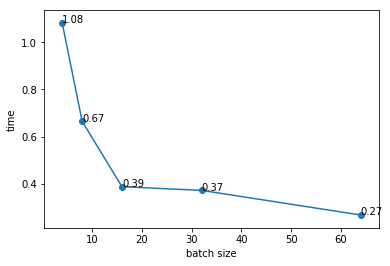

In [76]:
print('times:', times)
plt.figure()
plt.plot(batch_sizes, times)
plt.scatter(batch_sizes, times)
# plt.xticks(batch_sizes)
plt.xlabel('batch size')
plt.ylabel('time')
for i, time in enumerate(times):
    plt.annotate("%.2f"%(time), (batch_sizes[i], times[i]))
plt.show()


In [73]:
hidden_size, num_classes = 10, 6
learning_rate = 1e-2

def model_init_fn(inputs, is_training):
    return TwoLayerFC(hidden_size, num_classes)(inputs)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

errors, accuracies = train_part34(model_init_fn, optimizer_init_fn, num_epochs=100)
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
ax1.plot(range(len(errors)), errors)
ax2.plot(range(len(accuracies)), accuracies)
plt.xlabel('epoch')
ax1.set_ylabel('Train Errors')
ax2.set_ylabel('Validation accuracy')
plt.show()

In [89]:
train_dset = Dataset(X_train, y_train, batch_size=32, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=32, shuffle=True)
test_dset = Dataset(X_test, y_test, batch_size=32)

hidden_sizes = [5, 10, 15, 20, 25]
num_epoch = 100
acc = []
err = []
for size in hidden_sizes:
    print('hidden size:', size)
    hidden_size = size
    errors, accuracies = train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epoch)
    acc.append(accuracies)
    err.append(errors)

hidden size: 5
hidden size: 10
hidden size: 15
hidden size: 20
hidden size: 25


In [91]:
def plot_err_acc(err, acc, hyperparam, label):
    n = len(hyperparam)
    num_epoch = len(err[0])
    fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1) 
    for i in range(n):
        ax1.plot(range(num_epoch), err[i], label='{} = {}'.format(label, hyperparam[i]))
        ax2.plot(range(num_epoch), acc[i], label='{} = {}'.format(label, hyperparam[i]))

    plt.xlabel('epoch')
    ax1.set_ylabel('Train Errors')
    ax2.set_ylabel('Validation accuracy')
    # ax1.legend(loc='upper right')
    # ax2.legend(loc='upper right')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [92]:
plot_err_acc(err, acc, hidden_sizes, 'hidden size')

In [95]:
hidden_sizes = [5, 10, 15, 20, 25]
times = []
for size in hidden_sizes:
    print('hidden size:', size)
    hidden_size = size
    t = time_function(train_part34, model_init_fn, optimizer_init_fn, 100) / 100
    times.append(t)
print(times)

hidden size: 5
hidden size: 10
hidden size: 15
hidden size: 20
hidden size: 25
[0.10445247888565064, 0.10842635154724121, 0.11401114225387574, 0.11513923168182373, 0.14765834093093871]


In [100]:
def plot_time(times, hyperparam, label):
    plt.figure()
    plt.plot(hyperparam, times)
    plt.scatter(hyperparam, times)
    plt.xlabel(label)
    plt.ylabel('time')
    for i, time in enumerate(times):
        plt.annotate("%.3f"%(time), (hyperparam[i], times[i]))
    plt.show()

In [101]:
plot_time(times, hidden_sizes, 'hidden size')